In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 61

 ****************** Training and validation sets have been prepared **************** 

 prepare_single_data 
 prepare_semisingle_data 
 prepare_mix_data


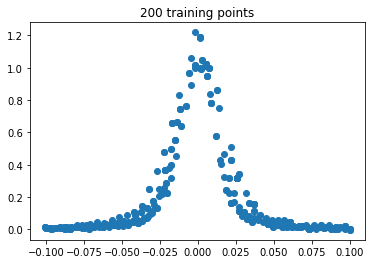

In [276]:
mode = 'Mixture'
%run EELS-ZLP.py

### Find uncertainties on data

44475


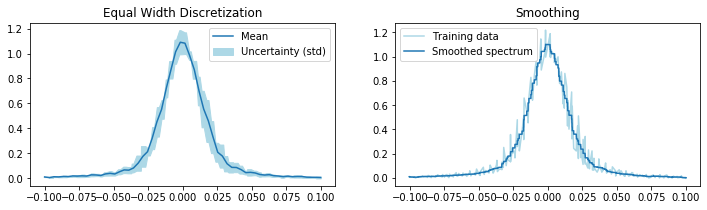

In [303]:
%run Functions.ipynb
fig = plt.gcf()

nbins = 60

if mode == 'Mixture':
    x_train, y_train, x_val, y_val = prepare_mix_data()
if mode == 'Single':
    x_train, y_train = prepare_single_data()

# Create a plot of the mean & std 
plt.subplot(1, 2, 1)
plot_uncertainties(x_train, y_train, nbins)
plt.title('Equal Width Discretization')
fig.set_size_inches(12, 5)


# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]

# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]


### Apply smoothing to the signal
smooth_y = smooth(df_train[:,1], 2000)
plt.subplot(1,2, 2)
plt.plot(df_train[:,0], df_train[:,1],  color='lightblue', label='Training data')
plt.plot(df_train[:,0], smooth_y, label='Smoothed spectrum')
fig.set_size_inches(12,3)
plt.title('Smoothing')
plt.legend()
plt.show()




## Neural Network 

### Create architecture

In [268]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(x, 5, activation=tf.nn.relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.relu)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    #hidden_layer_4 = tf.nn.dropout(hidden_layer_3, 0.01)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

### Prepare data for training

In [269]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train)
N_test = len(df_val)

train_x = np.array((df_train[:,0])).reshape(N_train,1)
train_y = np.array(df_train[:,1]).reshape(N_train,1)
train_sigma = np.array(df_train[:,2]).reshape(N_train,1)
train_y += np.random.normal(0, train_sigma)

test_x = np.array((df_val[:,0])).reshape(N_test,1)
test_y = np.array(df_val[:,1]).reshape(N_test,1)
test_sigma = np.array(df_val[:,2]).reshape(N_test,1)
test_y += np.random.normal(0, test_sigma)


predictions = make_model(x, 1)

cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(cost)

### Train and validate

In [270]:
training_epochs = 10000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 500
prev_test_cost = np.inf
prev_epoch=0
avg_cost = 0.0

array_train = []
array_test = []
print("Start training on", '%04d' %(N_train), "samples")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x, 
                            y: train_y, 
                            sigma: train_sigma
                        })
        
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
            array_train.append(avg_cost)
            array_test.append(test_cost)
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The session stopped because of overfitting...","red"))
            print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
            break
            
        elif test_cost < prev_test_cost:
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x, 
                            y: train_y
                        })

Start training on 43917 samples
Epoch: 0001 | Training cost= 35.257324219 | Validation cost= 33.478328705
Epoch: 0501 | Training cost= 12.789772034 | Validation cost= 12.488660812
Epoch: 1001 | Training cost= 3.559864759 | Validation cost= 3.544952393
Epoch: 1501 | Training cost= 3.033999443 | Validation cost= 3.013579130
Epoch: 2001 | Training cost= 2.896520615 | Validation cost= 2.889801502
Epoch: 2501 | Training cost= 2.865046263 | Validation cost= 2.857407093
Epoch: 3001 | Training cost= 2.860801458 | Validation cost= 2.853118181
Epoch: 3501 | Training cost= 2.858151913 | Validation cost= 2.849411011
Epoch: 4001 | Training cost= 2.856438637 | Validation cost= 2.847372293
Epoch: 4501 | Training cost= 2.836153269 | Validation cost= 2.822721958
Epoch: 5001 | Training cost= 2.835420609 | Validation cost= 2.821305752
Epoch: 5501 | Training cost= 2.837698698 | Validation cost= 2.824228764
Epoch: 6001 | Training cost= 2.835411072 | Validation cost= 2.820034266
Epoch: 6501 | Training cost=

### Plot outputs

43917


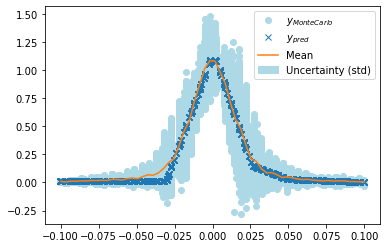

In [274]:


plt.plot(train_x, train_y, 'o', label='$y_{MonteCarlo}$', color='lightblue')
plt.plot(train_x, predictions_values, 'x', label='$y_{pred}$')
plot_uncertainties(x_train, y_train, nbins)
plt.legend()
plt.show()

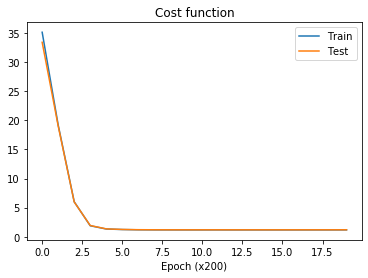

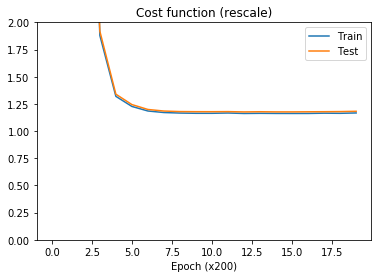

In [243]:
plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function')
plt.legend()
plt.show()

plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function (rescale)')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function (rescale)')
plt.ylim([0,2])
plt.legend()
plt.show()

